In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()

M = 11.6
m = 2.7
l = 0.57
g = 9.81

def z_dot(z, t, u):
    x = z[0]
    theta = z[1]
    x_dot = z[2]
    theta_dot = z[3]
    x_dot_dot =m*(g*np.cos(theta) - l*theta_dot**2)*np.sin(theta)/(M+m*np.sin(theta)**2) + u/(M+m*np.sin(theta)**2)
    theta_dot_dot = (g*(M+m)-l*m*theta**2*np.cos(theta))*np.sin(theta)/(l*(M+m*np.sin(theta)**2)) + u/(l*(M+m*np.sin(theta)**2))
    return [x_dot, theta_dot, x_dot_dot, theta_dot_dot]


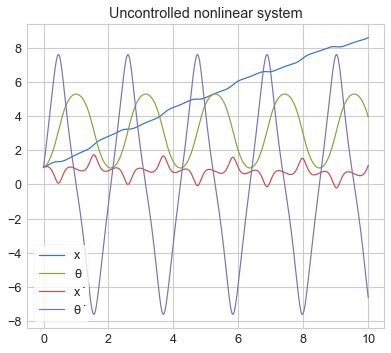

In [3]:
# Simulating it without any control
time = np.linspace(0, 10, 1000)
z_0 = [1, 1, 1, 1]
solution = odeint(z_dot, z_0, time, args=(0,))
plt.plot(time, solution)
plt.title("Uncontrolled nonlinear system")
plt.legend(['x', 'θ', 'x ̇', 'θ ̇'])
plt.show()

In [4]:
A_linear = np.matrix([[0, 0, 1, 0],
                      [0, 0, 0, 1],
                      [0, 2.28, 0, 0],
                      [0, 12.09, 0, 0]])
B_linear = np.matrix([[0],
                      [0], 
                      [0.8],
                      [0.15]])
# Controller
K = np.matrix([[-12.23, 246.1, -25.48, 75.48]])

controlled_A = A_linear - B_linear@K
def linearized(x, t):
    return np.asarray(controlled_A@x).reshape(-1)

In [5]:
# Luenberg observer
A = np.matrix([[ -7,  0, 1, 0],
               [  0, -3, 0, 1],
               [-12,  0, 0, 0],
               [  0, -2, 0, 0]])
B = B_linear
L = np.matrix([[1.9,  0.8],
               [0.8,  5.1],
               [1.6,  3.5],
               [2.1, 12.8]])
C = np.matrix([[1, 0, 0, 0],
               [0, 1, 0, 0]])
LC = L@C
def observer(x_hat, t, u, x):
    return (A@x_hat + (B@u).A1 + LC@(x - x_hat)).A1

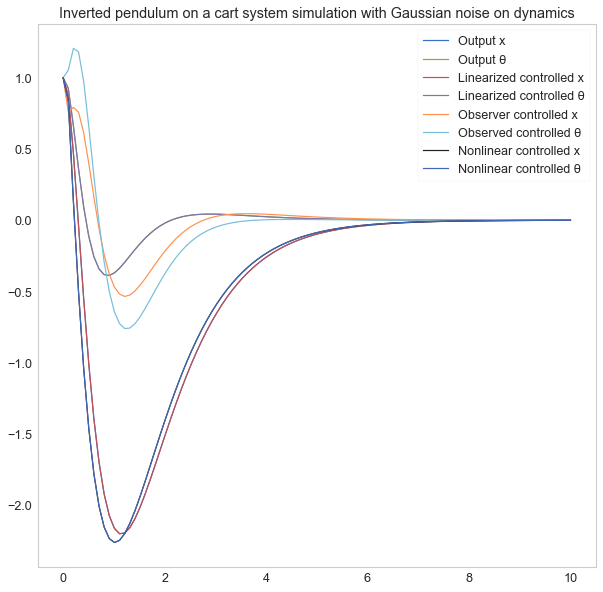

In [7]:

samples = 100
t0 = 0
tf = 10
time = np.linspace(t0, tf, samples)
x_0 = np.array([1, 1, 1, 1])    # initial conditions
y = [(C@x_0).A1]
xs = [x_0]
x_hats = [x_0]
zs = [x_0]
for i in range(1, samples):
    local_time = np.linspace(time[i-1], time[i])  # for better accuracy on a small time interval
    u = (K@x_0).A1          # calculate control
    noise = 0#np.random.normal()  # Gaussian noise
    noise2 = 0#np.random.normal()  # another Gaussian noise
    x = odeint(linearized, x_0, local_time)   
    x_0 = x[-1] + noise2    # new starting point is current end point
    xs.append(x_0)    # save the state of the current time snapshot
    y.append((C@x_0).A1) # linearize system output
    x_hat = odeint(observer, x_hats[-1], local_time, args=(u, x_0 + noise))
    x_hats.append(x_hat[-1])
    z = odeint(z_dot, x_0, local_time, args=(u,))   # solve the nonlinear system using the same control
    zs.append(z[-1])
    
y = np.array(y)
xs = np.array(xs)
x_hats = np.array(x_hats)
zs = np.array(zs)
plt.figure(figsize=(10, 10))
plt.title("Inverted pendulum on a cart system simulation with Gaussian noise on dynamics")
plt.plot(time, y[:, 0], label="Output x")
plt.plot(time, y[:, 1], label="Output θ")
plt.plot(time, xs[:, 0], label="Linearized controlled x")
plt.plot(time, xs[:, 1], label="Linearized controlled θ")
plt.plot(time, x_hats[:, 0], label="Observer controlled x")
plt.plot(time, x_hats[:, 1], label="Observed controlled θ")
plt.plot(time, zs[:, 0], label="Nonlinear controlled x")
plt.plot(time, zs[:, 0], label="Nonlinear controlled θ")
plt.grid()
plt.legend()